In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
import dlib
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 각 레이블 별 데이터셋 갯수

In [2]:
print(len(os.listdir("../input/drowsiness-dataset/train/Closed")))
print(len(os.listdir("../input/drowsiness-dataset/train/Open")))
print(len(os.listdir("../input/drowsiness-dataset/train/no_yawn")))
print(len(os.listdir("../input/drowsiness-dataset/train/yawn")))

726
726
725
723


# 이미지 파일

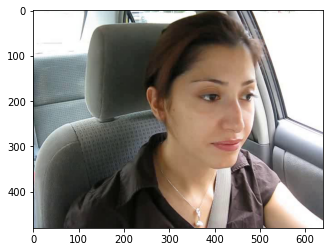

In [3]:
# yawn(하품), no_yawn(정상) 
# plt.imshow(plt.imread("../input/drowsiness-dataset/train/yawn/1.jpg"))
plt.imshow(plt.imread("../input/drowsiness-dataset/train/no_yawn/1.jpg"))

# Open, Closed 이미지
# plt.imshow(plt.imread("../input/drowsiness-dataset/train/Closed/_1.jpg"))
# plt.imshow(plt.imread("../input/drowsiness-dataset/train/Open/_1.jpg"))


# Label 

In [4]:
labels = os.listdir("../input/drowsiness-dataset/train")
labels

['Closed', 'Open', 'yawn', 'no_yawn']

# 얼굴 검출 및 분석을 위한 전처리

In [5]:
def face_for_yawn(direc="../input/drowsiness-dataset/train", face_cas_path="../input/prediction-images/haarcascade_frontalface_default.xml"):
    yaw_no = []    
    IMG_SIZE = 145 # 이미지 크기
    categories = ["yawn", "no_yawn"] # 카테고리 : 하품,정상
    
    # yawn과 no_yawn의 사진들 순회하기
    for category in categories: 
        path_link = os.path.join(direc, category) # 하품사진, 정상사진 경로 생성 (경로를 병합하여 새 경로 생성)
        class_num1 = categories.index(category)   # categories의 인덱스(0,1)
        print(class_num1) # 0 또는 1 순회확인
        
        # 디렉토리 안의 사진들 탐색 및 얼굴검출
        for image in os.listdir(path_link): 
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR) # 이미지파일은 color로 읽어들여 array로 변환
            face_cascade = cv2.CascadeClassifier(face_cas_path) # Cascade Classifier 불러옴
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)  # Cascade분류기의 detectMultiScale
                                                                        # 입력 영상 image에서 다양한 크기의 얼굴객체 사각형 영역(x,y,w,h)을 검출
                                                                        # detectMultiScale(input_array, ScaleFactor, MinNeighbor)
            # 얼굴좌표에 사각형 그리기        
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)  # cv2.rectangle()로 좌표받아 사각형 그리기
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1]) # 리스트에 [arr,레이블] 형태로 저장
                
    return yaw_no # yawn, no_yawn 사진들에서 얼굴영역에 사각형을 그린 것을 resize한 이미지 


yawn_no_yawn = face_for_yawn()

0
1


In [6]:
def get_data(dir_path="../input/drowsiness-dataset/train/", face_cas="../input/prediction-images/haarcascade_frontalface_default.xml", 
             eye_cas="../input/prediction-images/haarcascade.xml"):
    labels = ['Closed', 'Open'] # Open, Closed lable
    IMG_SIZE = 145  # 이미지 크기
    data = []
    
    # 사진 디렉토리 순회
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        
        # 탐색 및 resize
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
                
    return data

In [7]:
# face_for_yawn에 data(눈 뜬것/감은것)추가하여 다시 검출
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data() # data는 open/closed 사진들 전처리한 이미지
    yaw_no.extend(data) # 기존 yawn, no_yawn 전처리한 것에 추가
    return np.array(yaw_no) # array형태로 반환

In [8]:
new_data = append_data() # 전처리한 데이터 생성

X = []
y = []
for feature, label in new_data: # (이미지,레이블) 형태의 데이터를 각각 리스트에 따로 담기
    X.append(feature) # 이미지
    y.append(label)   # 정답값
    
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

0
1
2
3


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


# LabelEncoding

In [9]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)
y = np.array(y)

# train_test_split을 통한 검증 데이터셋 만들기

In [10]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

# Data Augmentation으로 학습데이터 추가생성

In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model 설계

In [13]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
import tensorflow as tf

In [14]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 143, 143, 256)     7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 71, 71, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 69, 69, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        1

# train, test dataset에 대한 정확도 확인

Epoch 1/50
43/43 [==============================] - 32s 585ms/step - loss: 1.3609 - accuracy: 0.3742 - val_loss: 0.7846 - val_accuracy: 0.6990
Epoch 2/50
43/43 [==============================] - 24s 564ms/step - loss: 0.6406 - accuracy: 0.7291 - val_loss: 0.4431 - val_accuracy: 0.7855
Epoch 3/50
43/43 [==============================] - 24s 562ms/step - loss: 0.4731 - accuracy: 0.8109 - val_loss: 0.3554 - val_accuracy: 0.8772
Epoch 4/50
43/43 [==============================] - 24s 562ms/step - loss: 0.3748 - accuracy: 0.8539 - val_loss: 0.2924 - val_accuracy: 0.8858
Epoch 5/50
43/43 [==============================] - 24s 563ms/step - loss: 0.3073 - accuracy: 0.8718 - val_loss: 0.4996 - val_accuracy: 0.8218
Epoch 6/50
43/43 [==============================] - 24s 563ms/step - loss: 0.2979 - accuracy: 0.8705 - val_loss: 0.2462 - val_accuracy: 0.9152
Epoch 7/50
43/43 [==============================] - 24s 562ms/step - loss: 0.2297 - accuracy: 0.9048 - val_loss: 0.2241 - val_accuracy: 0.9239

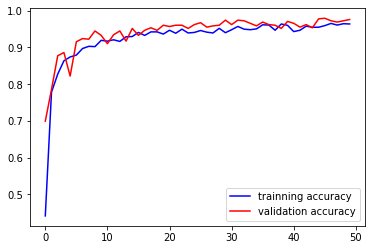

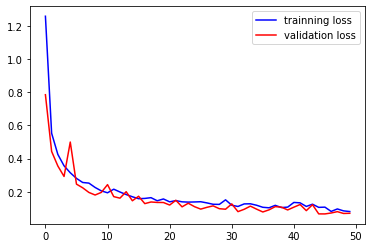

In [15]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [16]:
model.save("drowiness_model.h5") # 학습 가중치 저장
model.save("drowiness_model.model") # 모델 저장

In [17]:
prediction = model.predict_classes(X_test)
prediction

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([3, 3, 2, 3, 1, 3, 3, 2, 1, 2, 3, 3, 3, 2, 2, 2, 3, 0, 0, 2, 3, 3,
       2, 1, 0, 2, 2, 2, 3, 2, 3, 2, 3, 2, 0, 3, 3, 2, 1, 3, 3, 3, 2, 3,
       2, 2, 3, 3, 2, 3, 3, 1, 2, 1, 2, 3, 2, 2, 2, 0, 3, 3, 1, 2, 2, 3,
       2, 3, 2, 2, 1, 3, 3, 3, 2, 0, 0, 3, 1, 3, 2, 1, 3, 2, 2, 2, 2, 0,
       3, 3, 2, 3, 3, 3, 1, 0, 3, 0, 3, 3, 3, 1, 3, 1, 2, 3, 2, 1, 2, 2,
       1, 1, 2, 1, 0, 3, 3, 3, 2, 2, 3, 3, 3, 1, 1, 2, 3, 3, 2, 1, 3, 3,
       1, 3, 1, 2, 3, 3, 3, 1, 2, 2, 2, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3,
       3, 0, 1, 0, 3, 1, 3, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 1, 2, 0, 3, 3,
       2, 2, 0, 2, 3, 0, 2, 1, 3, 1, 3, 1, 2, 0, 1, 3, 2, 3, 3, 2, 3, 0,
       3, 2, 3, 0, 2, 0, 0, 1, 2, 3, 2, 0, 3, 0, 2, 2, 2, 2, 1, 3, 1, 1,
       1, 1, 2, 3, 3, 3, 3, 0, 0, 2, 0, 0, 3, 3, 1, 3, 3, 0, 3, 3, 1, 0,
       0, 0, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 0, 2, 2, 2, 0, 3, 3, 2, 2,
       3, 2, 2, 1, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 0, 1, 0, 3, 3, 3, 3, 2,
       2, 1, 2, 2, 3, 3, 2, 0, 2, 2, 1, 3, 2, 3, 1,

# 분류 리포트

In [19]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=["yawn", "no_yawn", "Closed", "Open"]))

              precision    recall  f1-score   support

        yawn       0.93      0.87      0.90        63
     no_yawn       0.88      0.95      0.91        74
      Closed       0.98      0.93      0.95       215
        Open       0.95      0.98      0.96       226

    accuracy                           0.95       578
   macro avg       0.93      0.93      0.93       578
weighted avg       0.95      0.95      0.95       578

